### Imports

In [4]:
# data handling
import numpy    as np
import xarray   as xr

# math
from scipy.stats import norm

# plotting
import matplotlib.pyplot as pyp
import cmocean

### Helper Functions

In [5]:
def plot_current_field(x_grid, y_grid, ds, skip=75, Uq = 0.5, q_scale=10):
    speed = np.sqrt(ds.u**2 + ds.v**2)

    fig, ax = pyp.subplots(figsize=(12, 6))

    c = ax.contourf(x_grid, y_grid, speed, cmap=cmocean.cm.speed, levels=50)
    fig.colorbar(c, ax=ax, label='Speed [m/s]')

    q = ax.quiver(x_grid[::skip, ::skip], y_grid[::skip, ::skip], 
                  ds.u[::skip, ::skip], ds.v[::skip, ::skip], 
                  color='black', scale=q_scale, width=0.0025)
    ax.quiverkey(q, X=0.9, Y=-0.1, U=Uq, label=f'{Uq} [m/s]', labelpos='E')

    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.set_title('Current Velocity Magnitude and Direction')

    ax.set_aspect('equal')

    pyp.show()

In [6]:
def edge_taper(u_field, v_field, x_grid, y_grid, Lx, Ly, taper_radius=1000):
    """
    Applies a Gaussian edge taper to the velocity field to make it smoothly decay
    to zero at the edges.
    """
    x_dist = np.abs(x_grid - Lx / 2) / taper_radius
    y_dist = np.abs(y_grid - Ly / 2) / taper_radius
    
    gaussian_decay = np.exp(-0.5 * (x_dist**2 + y_dist**2))

    u_tapered = u_field * gaussian_decay
    v_tapered = v_field * gaussian_decay
    
    return u_tapered, v_tapered

In [7]:
def edge_taper_tmp(field, xv, yv, Lx, Ly, taper_radius=1000):
    """
    Applies a Gaussian edge taper to the velocity field to make it smoothly decay
    to zero at the edges.
    """
    x_dist = np.abs(xv - Lx / 2) / taper_radius
    y_dist = np.abs(yv - Ly / 2) / taper_radius
    
    gaussian_decay = np.exp(-0.5 * (x_dist**2 + y_dist**2))

    tapered = field * gaussian_decay
    
    return tapered

# Creating Canonical Forcing Fields

## Introduction

This notebook will cover the synthesizing of the following forcing fields:
1) A homogeneous current field,
2) A zonal current jet,
3) A mesoscale eddy,
4) A constant bathymetry field,
5) and an idealized island.

All fields will be steady (no variation in time).

In [8]:
output_dir = 'data/'

# Domain Parameters

For these synthesized datasets, we will be using a 10 km by 20 km domain with 0.1 km grid spacing. 

In [ ]:
# Parameters for the background domain (meters)
Lx = 200000 # x-length
Ly = 100000 # y-length 
dx = 2500  # x grid spacing
dy = 2500  # y grid spacing

# x/y grid
x = np.arange(0, Lx, dx)
y = np.arange(0, Ly, dy)
xv, yv = np.meshgrid(x, y)

# Homogeneous Field

This field will have the same u/v velocity at all grid points.

In [47]:
# Choose a u/v current speed [m/s]
u = 0
v = 0

In [48]:
# Fill arrays with u/v
U_homog = np.full_like(xv, u)
V_homog = np.full_like(yv, v)

In [49]:
# build into a dataset
ds_homog = xr.Dataset(
    data_vars={
        "x": (["x"], x),
        "y": (["y"], y),
        "u": (["y", "x"], U_homog, {"long_name": "zonal current velocity", "units": "m/s"}),
        "v": (["y", "x"], V_homog, {"long_name": "meridional current velocity", "units": "m/s"}),
    }
)

Note: data must be saved using the `NETCDF3_CLASSIC` format.

In [50]:
ds_homog.to_netcdf(output_dir+'currents/homogeneous.nc', format="NETCDF3_CLASSIC")

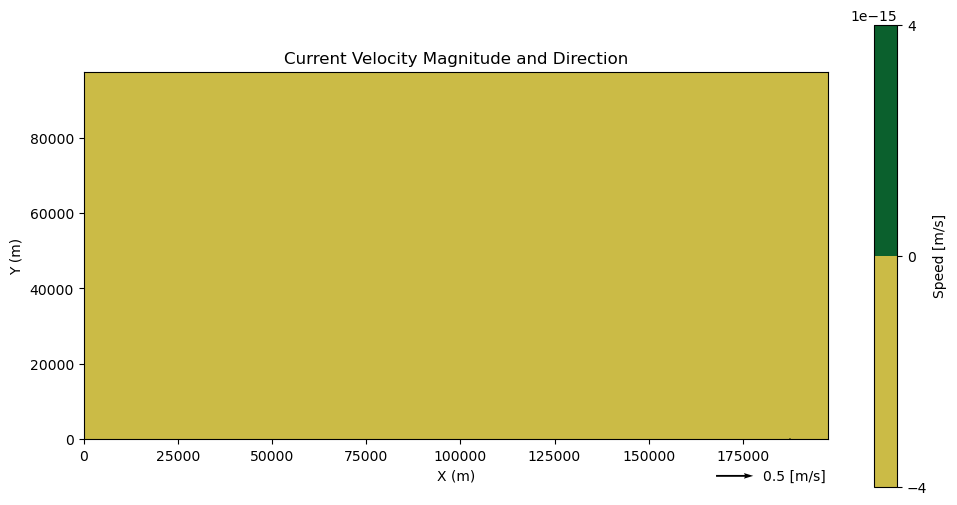

In [51]:
# Plot using helper function
plot_current_field(xv, yv, ds_homog)

# Zonal Jet

This field will have a zonal current jet whose profile follows a Gaussian distribution:
$$
f(x) = A \cdot e^{-\frac{(x-\mu)^2}{2\sigma^2}}
$$

In [52]:
# Choose the maximum speed of the jet [m/s]
U_max = 0.3
width = 0.25

In [53]:
x_profile = np.linspace(-1, 1, len(y))
U_profile = U_max * np.exp((-x_profile**2) / (2 * width**2))

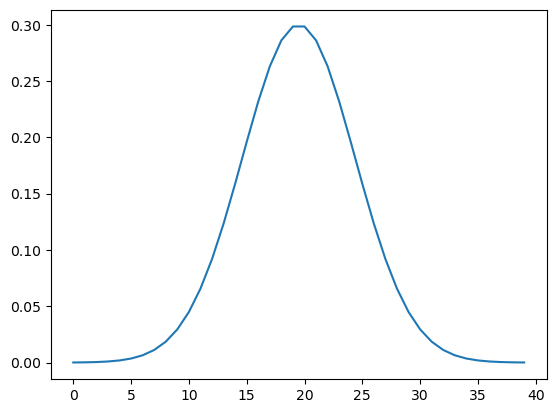

In [54]:
pyp.plot(U_profile)

We extend the profile along the x-axis and assume there is no zonal current.

In [55]:
U_jet = np.ones((len(y), len(x))) * U_profile[:, np.newaxis]
V_jet = np.zeros_like(U_jet)

In [56]:
ds_jet = xr.Dataset(
    data_vars={
        "x": (["x"], x),
        "y": (["y"], y),
        "u": (["y", "x"], U_jet, {"long_name": "zonal current velocity", "units": "m/s"}),
        "v": (["y", "x"], V_jet, {"long_name": "meridional current velocity", "units": "m/s"}),
    }
)

In [57]:
ds_jet.to_netcdf(output_dir+'currents/jet.nc', format="NETCDF3_CLASSIC")

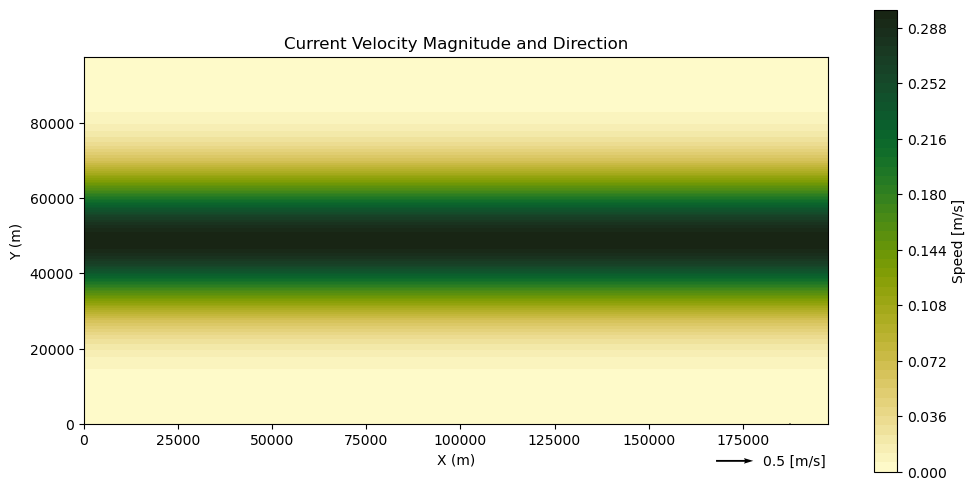

In [58]:
plot_current_field(xv, yv, ds_jet)

## Mesoscale Eddy

We will make a realistic submesoscale eddy (1's of km across) and insert it into a larger static domain.

In [96]:
# Parameters for the smaller eddy domain
Lx_eddy = 100000  # meters
Ly_eddy = 100000  # meters

In [97]:
# Grid for smaller eddy domain
x_eddy = np.arange(0, Lx_eddy, dx)
y_eddy = np.arange(0, Ly_eddy, dy)
xv_eddy, yv_eddy = np.meshgrid(x_eddy, y_eddy)

The u/v velocity components are constructed such that the center of the eddy is low velocity.

In [98]:
# Eddy velocity field
u_eddy = np.pi  * np.sin(np.pi * xv_eddy / Lx_eddy) * np.cos(np.pi * yv_eddy / Ly_eddy)
v_eddy = -np.pi * np.cos(np.pi * xv_eddy / Lx_eddy) * np.sin(np.pi * yv_eddy / Ly_eddy)

Velocities in submesoscale eddies are around 15 cm/s. A scaling factor of 2 brings the max velocity to around 17 cm/s.

In [99]:
u_eddy /= 2
v_eddy /= 2

We apply a Gaussian weighting to make the eddy more localized.

In [100]:
# Apply Gaussian weighting to make the eddy more localized
x_weight = norm.pdf(x_eddy, loc=Lx_eddy / 2, scale=Lx_eddy / 6)
y_weight = norm.pdf(y_eddy, loc=Ly_eddy / 2, scale=Ly_eddy / 6)

# Normalize weights
x_weight /= x_weight.max()
y_weight /= y_weight.max()

# Apply weights using broadcasting
u_eddy *= x_weight[np.newaxis, :]
u_eddy *= y_weight[:, np.newaxis]
v_eddy *= x_weight[np.newaxis, :]
v_eddy *= y_weight[:, np.newaxis]

The edges of the eddy are tapered with a custom function to make sure there are no sharp transitions between the background static field and the eddy.

In [101]:
# Apply the edge taper
u_eddy_tapered, v_eddy_tapered = edge_taper(u_eddy, v_eddy, 
                                            xv_eddy, yv_eddy, 
                                            Lx_eddy, Ly_eddy, 
                                            taper_radius=Lx_eddy/3)

We now insert the eddy into a larger domain. We define the center of the eddy using the units of the domain.

In [107]:
# Define the center of the eddy [m]
center_x = 75000
center_y = 50000

In [108]:
# Create static background velocity field
u_background = np.zeros_like(xv)
v_background = np.zeros_like(yv)

idx_center_x = int((center_x - Lx_eddy/2) / dx)
idx_center_y = int((center_y - Ly_eddy/2) / dy)

# Insert the tapered eddy
u_background[idx_center_y:idx_center_y + len(y_eddy), 
             idx_center_x:idx_center_x + len(x_eddy)] += u_eddy_tapered
v_background[idx_center_y:idx_center_y + len(y_eddy), 
             idx_center_x:idx_center_x + len(x_eddy)] += v_eddy_tapered

In [109]:
ds_eddy = xr.Dataset(
    data_vars={
        "x": (["x"], x),
        "y": (["y"], y),
        "u": (["y", "x"], u_background, {"long_name": "zonal current velocity", "units": "m/s"}),
        "v": (["y", "x"], v_background, {"long_name": "meridional current velocity", "units": "m/s"}),
    }
)

In [110]:
ds_eddy.to_netcdf(output_dir+'currents/eddy.nc', format="NETCDF3_CLASSIC")

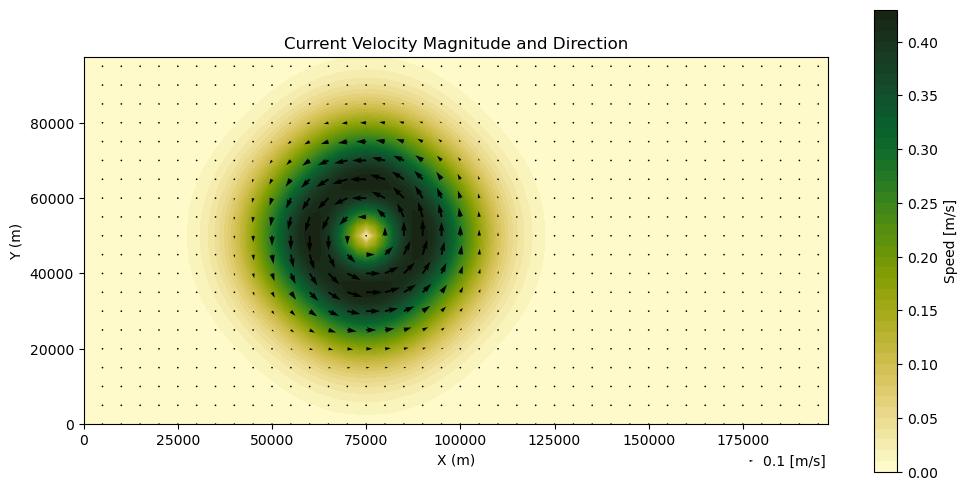

In [111]:
plot_current_field(xv, yv, ds_eddy, skip=2, Uq=0.1, q_scale=20)

## Constant Bathymetry

For the different current examples, we will use a constant deep bathymetry field.

In [112]:
bathy_const = np.full_like(xv, 4000) # [m]

In [113]:
ds_const = xr.Dataset(
    data_vars={
        "x": (["x"], x),
        "y": (["y"], y),
        "depth": (["y", "x"], bathy_const, {"long_name": "bathymetry", "units": "m"})
    }
)

In [114]:
ds_const.to_netcdf(output_dir+'bathymetry/constant.nc', format="NETCDF3_CLASSIC")

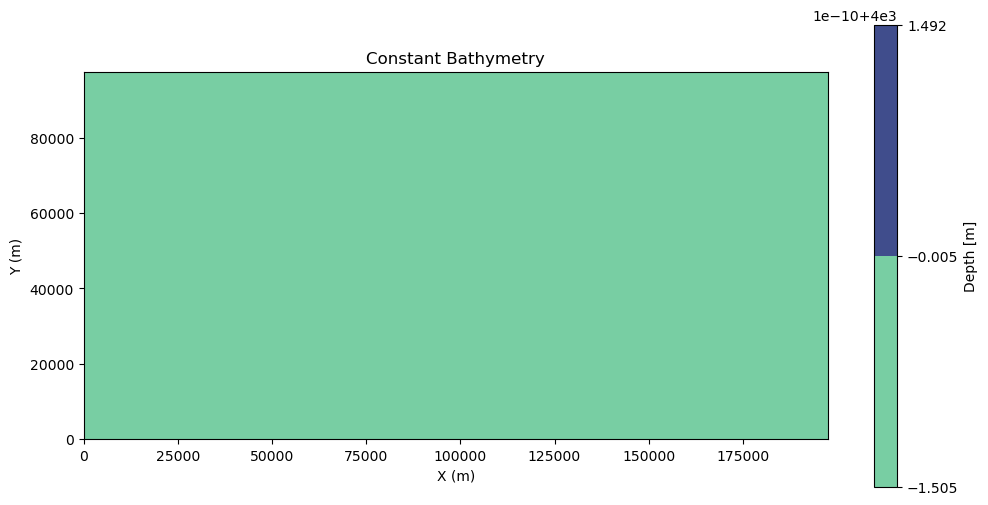

In [115]:
fig, ax = pyp.subplots(figsize=(12, 6))

c = ax.contourf(xv, yv, bathy_const, cmap=cmocean.cm.deep)

fig.colorbar(c, ax=ax, label='Depth [m]')

ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')

ax.set_title('Constant Bathymetry')

ax.set_aspect('equal')

pyp.show()

## Gaussian Island

We will also show an example of no currents but with a perfectly Gaussian island mound. We will construct the dataset in a similar way as we constructed the eddy dataset.

In [142]:
# Island parameters [m]
Lx_island = 100000
Ly_island = 100000
H         = 100    # background depth
elevation = 50     # max elevation of the island

In [143]:
# Grid for the island
x_island = np.arange(0, Lx_island, dx)
y_island = np.arange(0, Ly_island, dy)
xv_island, yv_island = np.meshgrid(x_island, y_island)

In [144]:
# Create Gaussian bump for the island
x_weight = norm.pdf(x_island, loc=Lx_island / 2, scale=Lx_island / 6)
y_weight = norm.pdf(y_island, loc=Ly_island / 2, scale=Ly_island / 6)

# Normalize weights so the peak is 1
x_weight /= x_weight.max()
y_weight /= y_weight.max()

# Compute the full 2D Gaussian bum, scaled by the depth + elevation
island_bump = (H + elevation) * np.outer(y_weight, x_weight)

In [145]:
# Define island center in the larger bathymetry field
center_x = 100000  # meters
center_y = 50000   # meters

In [146]:
idx_center_x = int((center_x - Lx_island / 2) / dx)
idx_center_y = int((center_y - Ly_island / 2) / dy)

bathy_const = np.full_like(xv, H)

# Subtract the island bump from the bathymetry field
bathy_island = bathy_const.copy()
bathy_island[idx_center_y:idx_center_y + len(y_island), 
             idx_center_x:idx_center_x + len(x_island)] -= island_bump

In [147]:
tmp = edge_taper_tmp(island_bump, xv_island, yv_island, Lx_island, Ly_island, taper_radius=5000)
# Subtract the island bump from the bathymetry field
bathy_island = bathy_const.copy()
bathy_island[idx_center_y:idx_center_y + len(y_island), 
             idx_center_x:idx_center_x + len(x_island)] -= tmp

In [148]:
ds_island = xr.Dataset(
    data_vars={
        "x": (["x"], x),
        "y": (["y"], y),
        "depth": (["y", "x"], bathy_island, {"long_name": "bathymetry", "units": "m"})
    }
)

In [149]:
ds_island.to_netcdf(output_dir+'bathymetry/island.nc', format="NETCDF3_CLASSIC")

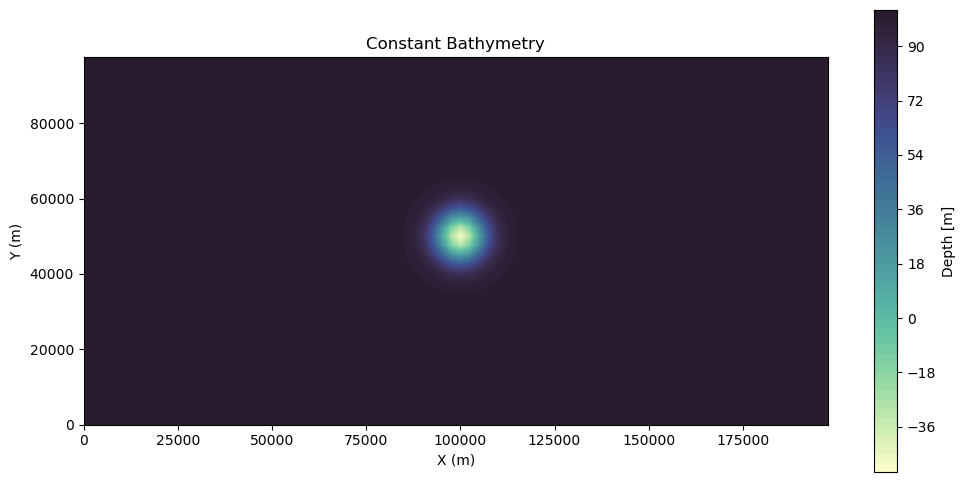

In [150]:
fig, ax = pyp.subplots(figsize=(12, 6))

c = ax.contourf(xv, yv, bathy_island, cmap=cmocean.cm.deep, levels=50)

fig.colorbar(c, ax=ax, label='Depth [m]')

ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')

ax.set_title('Constant Bathymetry')

ax.set_aspect('equal')

pyp.show()

Note: more positive depth is deeper, while more negative depth is above sea level.

## BONUS: Concertina Effect Exploration

In [25]:
# Choose a u/v current speed [m/s]
u = 1
v = 0

In [ ]:
# Fill arrays with u/v
V_cncrt = np.full_like(yv, v)

In [27]:
# build into a dataset
ds_cncrt = xr.Dataset(
    data_vars={
        "x": (["x"], x),
        "y": (["y"], y),
        "u": (["y", "x"], U_cncrt, {"long_name": "zonal current velocity", "units": "m/s"}),
        "v": (["y", "x"], V_cncrt, {"long_name": "meridional current velocity", "units": "m/s"}),
    }
)

In [28]:
ds_cncrt.to_netcdf(output_dir+'currents/concertina.nc', format="NETCDF3_CLASSIC")

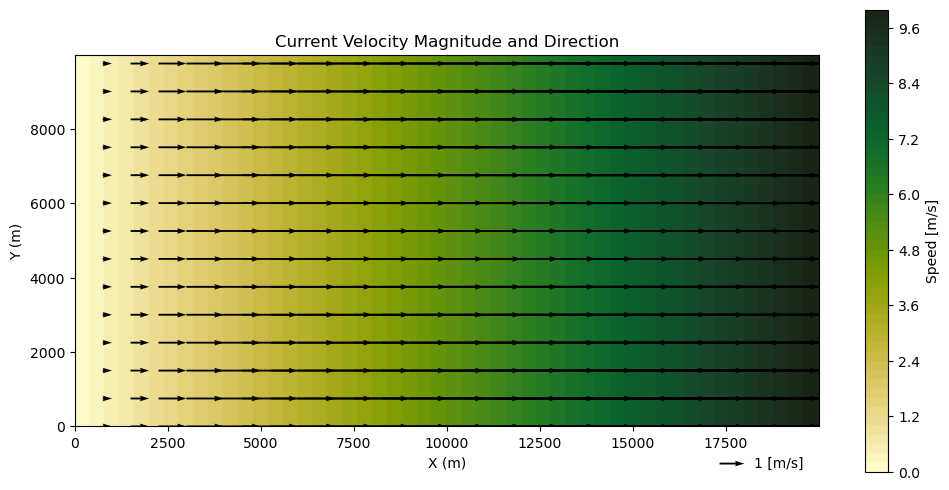

In [29]:
plot_current_field(xv, yv, ds_cncrt, Uq=1, q_scale = 30)

## BONUS: A Gentle Beach

In [43]:
bathy_beach = np.tile(np.linspace(250, -10, yv.shape[0])[:, np.newaxis], (1, yv.shape[1]))

In [45]:
ds_beach = xr.Dataset(
    data_vars={
        "x": (["x"], x),
        "y": (["y"], y),
        "depth": (["y", "x"], bathy_beach, {"long_name": "bathymetry", "units": "m"})
    }
)

In [46]:
ds_beach.to_netcdf(output_dir+'bathymetry/beach.nc', format="NETCDF3_CLASSIC")

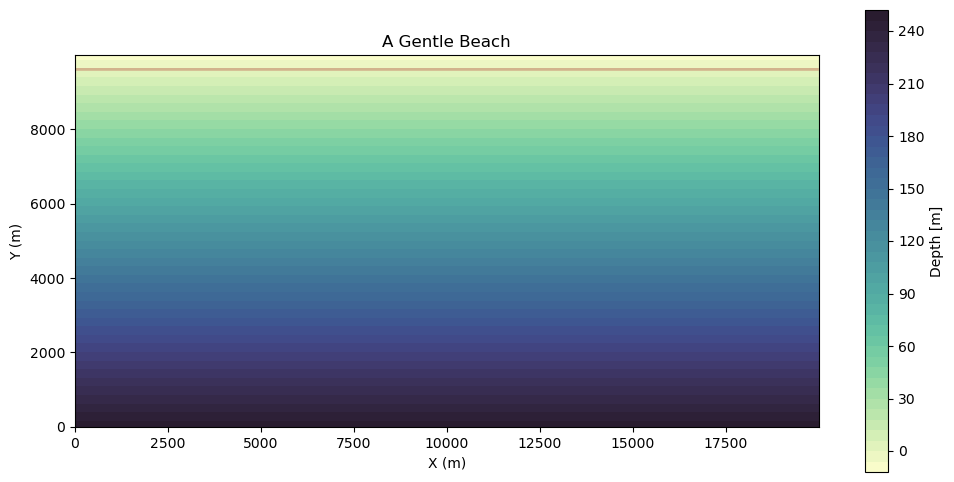

In [57]:
fig, ax = pyp.subplots(figsize=(12, 6))

# Filled contour plot
c = ax.contourf(xv, yv, bathy_beach, cmap=cmocean.cm.deep, levels=50)

# Add contour line at 0 depth
zero_contour = ax.contour(xv, yv, bathy_beach, levels=[0], colors='tan', linewidths=2)

fig.colorbar(c, ax=ax, label='Depth [m]')

ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_title('A Gentle Beach')

ax.set_aspect('equal')

pyp.show()